## Import Dependencies

In [1]:
# import general dependencies
import numpy as np
import pandas as pd
import os
import re
import time
import matplotlib.pyplot as plt
import matplotlib
import warnings
from tqdm import tqdm
%matplotlib inline

# import augmentation and librosa dependencies
import pydub
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import multiprocessing as mp
import librosa
import librosa.display as display

# import keras, tf and image depdencies
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import efficientnet.keras as efn 
from PIL import Image
from sklearn.utils import class_weight
import tensorflow_hub as hub
from tensorflow.keras import layers

# import kapre dependencies
from kapre.time_frequency import Melspectrogram
from kapre.utils import Normalization2D
from kapre.augmentation import AdditiveNoise
from kapre.time_frequency import Spectrogram

# suppress warnings
warnings.filterwarnings("ignore")

SOUND_DIR = "/project/data/"
SOUND_DIR_SUB = "/project/data/birdsong-recognition/train_audio/"

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Using TensorFlow backend.


Num GPUs Available:  1


## Utility Functions 

In [2]:
##########################################################
####  Function for creating Mel Spectrogram
##########################################################

def createMelSpectrogram(input_path, fileName, output_path, saveOrShow=0):
    
    # load sound signal
    signal, sr = librosa.load(os.path.join(input_path, fileName), duration=10)
    
    # create Mel Spectrogram
    S = Melspectrogram(n_dft=1024, 
                       n_hop=256,
                       input_shape=(1, signal.shape[0]),
                       padding='same', sr=sr, n_mels=224, fmin=1400, fmax=sr/2,
                       power_melgram=2.0, return_decibel_melgram=True,
                       trainable_fb=False, trainable_kernel=False)(signal.reshape(1, 1, -1)).numpy()
    
    S = S.reshape(S.shape[1], S.shape[2])
    
    if saveOrShow == 0:   
        matplotlib.image.imsave(os.path.join(output_path, fileName.split(".")[0] + ".png"), S)
    else:
        display.specshow(S, sr=sr)
        plt.show()

In [3]:
##########################################################
####  mp3 read and write methods. Credit to Stackoverflow
####  user Basj for the starting point for these 
####  methods in his answer to:
####  https://stackoverflow.com/questions/53633177/how-to-read-a-mp3-audio-file-into-a-numpy-array-save-a-numpy-array-to-mp3?noredirect=1&lq=1
####
####  The calling function passes a filename to
####  be read or written
####
####  Note the normalization - MP3s are rarely anything
####  other than 16 bit (signed 15 bit number), but there
####  is a faint chance this wouldn't work.
##########################################################

def mp3_read(filename, normalized=False):
    """Read mp3 file to numpy array"""
    with open(filename, "rb") as f:
        a = pydub.AudioSegment.from_mp3(f)
        y = np.array(a.get_array_of_samples()).astype('float64')
        if a.channels == 2:
            y = y.reshape((-1, 2))
            
        if normalized:
            return a.frame_rate, np.float32(y) / 2**15
        else:
            return a.frame_rate, y
    f.close()

    
def mp3_write(filename, sr, x, normalized=False):
    """Write numpy array to mp3 file"""
    with open(filename, "wb") as f:
        channels = 2 if (x.ndim == 2 and x.shape[1] == 2) else 1
        if normalized:  # normalized array - each item should be a float in [-1, 1)
            y = np.int16(x * 2 ** 15)
        else:
            y = np.int16(x)
        clip = pydub.AudioSegment(y.tobytes(), frame_rate=sr, sample_width=2, channels=channels)
        clip.export(f, format="mp3", bitrate=f"{sr * 2**16}")
    f.close()

In [4]:
##########################################################
####  Core function for augmentation of a single file 
##########################################################

def augment(source_file,dest_file,augmentation):
    """
    augment() - used for the multiprocessing
    later on to accelerate the creation of all the
    augmentations as fast as possible
    
    source_file:  path and filename of source sample
    dest_file:    path and filename of output sample
    augmentation: an instance of audiomentations.Compose
                  containing the augmentation(s)    
    
    If passed a stereo file, it will create two mono files
    from the two channels. If the passed file does not exist,
    then we look for it in the stereo subdirectory. If it
    does exist, it gets moved there after the split.
    """
    source_file0 = f"{source_file[:-4]}.0{source_file[-4:]}"
    source_file1 = f"{source_file[:-4]}.1{source_file[-4:]}"
    dest_file0 = f"{dest_file[:-4]}.0{dest_file[-4:]}"
    dest_file1 = f"{dest_file[:-4]}.1{dest_file[-4:]}"

    if(os.path.isfile(source_file0) and os.path.isfile(source_file1) and not(os.path.isfile(source_file))):
        # the stereo split has already been done, so augment each of 
        # the files. 
        augment(source_file0,dest_file0,augmentation)
        augment(source_file1,dest_file1,augmentation)

    else:
        # The file is either mono already or not yet split
        # Read information from the mp3 file
        try:            
            sample_rate, chirp = mp3_read(source_file)
        except:
            print(f"Problem encountered reading in {os.path.basename(source_file)}" )
            errors.append(source_file)
            return

            

        # If the chirp file is in stereo (two column array)
        # then create two mono files from the two channels
        # and run the augmentation on each of them.

        if (len(chirp.shape) == 2 and chirp.shape[1] == 2):
            # Recording is in stereo, splitting into two mono files

            # write the split mono files from the two channels
            mp3_write(source_file0, sample_rate, chirp[:,0], normalized=False)
            mp3_write(source_file1, sample_rate, chirp[:,1], normalized=False)

            # run augmentation on each
            augment(source_file0,dest_file0,augmentation)
            augment(source_file1,dest_file1,augmentation)          
            
            # move the stereo version of the file to a new location
            if not os.path.exists(os.path.dirname(source_file) + "/stereo/"): 
                os.mkdir(os.path.dirname(source_file) + "/stereo/")
                
            os.rename(source_file, f"{os.path.dirname(source_file)}/stereo/{os.path.basename(source_file)}")
         
        else:
            try:
                # file is mono, and we can process directly
                
                if( not(os.path.isfile(dest_file)) or os.path.getsize(dest_file) == 0 ):
                    new_chirp = augmentation(chirp, sample_rate=sample_rate) 
                    # Write out the new chirp audio to an mp3
                    mp3_write(dest_file, sample_rate, new_chirp, normalized=False)
            except:
                print(f"Problem encountered processing {os.path.basename(dest_file)}" )
                errors.append(dest_file)

In [5]:
###########################################################
####  Process a single directory of bird sounds
###########################################################

def augment_bird(bird):
    
    # add a random pause to avoid messages overwriting each other
    time.sleep(np.random.uniform(0,5))
    start_time = time.time()

    input_dir = os.path.join(SOUND_DIR_SUB, bird)
    # Ignore augmented files starting with "A"
    chirps = [f for f in os.listdir(input_dir) if re.match(r'X.*\.mp3', f)]
    
    print(f"\nCreating augmented samples from {len(chirps)} files for {bird}")

    # only enhance files that start with X - the generated files start with A
    for chirp in chirps:
    
        chirp_file = os.path.join(input_dir, chirp)

        # Augmentation 1 - random time shift + or - up to 0.5s
        augmentation = Compose([Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5)])
        dest_file =  os.path.join(input_dir, f"A.{chirp[:-4]}.ts0.5{chirp[-4:]}")
        augment(chirp_file, dest_file, augmentation)

        # Augmentation 2 - random frequency shift up or down by up to 2 semitones
        augmentation = Compose([PitchShift(min_semitones=-2, max_semitones=2, p=0.5)])
        dest_file =  os.path.join(input_dir, f"A.{chirp[:-4]}.fs2{chirp[-4:]}")
        augment(chirp_file, dest_file, augmentation)

        # Augmentation 3 - random time expansion / contraction up to 20%
        augmentation = Compose([TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5)])
        dest_file =  os.path.join(input_dir, f"A.{chirp[:-4]}.ex20{chirp[-4:]}")
        augment(chirp_file, dest_file, augmentation)

        # Augmentation 4 - add gaussian noise between 0.001 and 0.015 amplitude
        augmentation = Compose([AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5)])
        dest_file =  os.path.join(input_dir, f"A.{chirp[:-4]}.gn015{chirp[-4:]}")
        augment(chirp_file, dest_file, augmentation)

    duration = time.time() - start_time

    print(f"Augmentation complete in {time.strftime('%H:%M:%S', time.gmtime(duration))} " +\
          f"for {os.path.basename(input_dir)}")

In [6]:
###########################################################
####  Main function to augment all birds
###########################################################

def augment_multiple_birds(bird_list=["*"]):
    completed_birds = 0
    errors = []
    np.random.seed(1234)
    
    main_start = time.time()
    
    print("Start Time: ", time.strftime('%H:%M:%S', time.gmtime(main_start)))
    
    if bird_list[0] != "*":
        birds = bird_list
    else:
        birds = os.listdir(SOUND_DIR_SUB)
    
    birds.sort()
    total_birds = len(birds)

    print(birds)
    
    # comment out the next line and uncomment the following one if running
    # on non-hyperthreaded CPU cores. Assigns one thread per physical core
    # reserving one core for OS, IO, compression etc. when using cloud
    # object storage, or override with your own number.
    # I ran this on a 32 core processor.
    
    threads = int((mp.cpu_count() /2) - 1)
    # threads = int(mp.cpu_count() -2)
    # threads = 48

    # Handle single-core machines
    if (threads < 1): threads = 1
    print(f"Launching {threads} threads")
    pool = mp.Pool(threads)
    
    pool.map(augment_bird, birds)
    
    main_end = time.time()
    duration = main_end - main_start
    
    print(time.strftime('%H:%M:%S', time.gmtime(duration)))
    print("End Time: ", time.strftime('%H:%M:%S', time.gmtime(main_end)))

    print(f"Completed all augmentations in {time.strftime('%H:%M:%S', time.gmtime(duration))}")
    print()
    print(f"A total of {len(errors)} occurred, errors encountered generating:")
    for error in errors:
        print(error)

In [7]:
###########################################################
####  Gets headless model URl for transfer learning
####  See this for a complete list of models
####  https://tfhub.dev/s?fine-tunable=yes&module-type=image-feature-vector&tf-version=tf2&q=tf2
###########################################################

model_metadata_mapping = {
    "tf2_mobilenet_v2": ["https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/", (224,224,3)],
    "imgnet_mobilenet_v2_140_224": ["https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/", (224,224,3)],
    
    "imgnet_resnet_v2_50": ["https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/", (224,224,3)],
    "imgnet_resnet_v2_152" : ["https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/", (224,224,3)],
    "imgnet_inception_resnet_v2" : ["https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/", (299,299,3)],
    
    "tf2_inception_v3": ["https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/", (299,299,3)],
    "imgnet_inception_v3": ["https://tfhub.dev/google/imagenet/inception_v3/feature_vector/", (299,299,3)],
    
    "imgnet_pnasnet_large" : ["https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/",(331,331,3)],
    "imgnet_nasnet_mobile" : ["https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/", (224,224,3)]
}

def get_model_url(model_name, model_iteration=4):
    return model_metadata_mapping[model_name][0] + str(model_iteration)

def get_model_img_size(model_name):
    return model_metadata_mapping[model_name][1]


## Visualizing Mel-Spectrogram of an Audio Sample

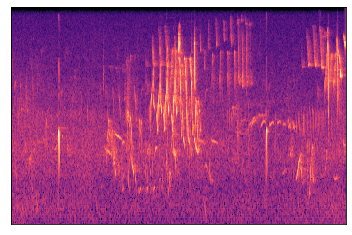

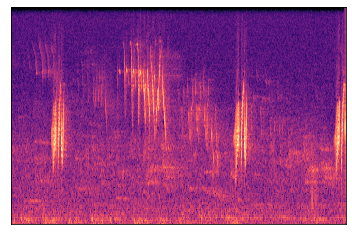

In [8]:
# bird: aldfly
createMelSpectrogram(SOUND_DIR_SUB + "aldfly", "XC134874.mp3", "", 1)
createMelSpectrogram(SOUND_DIR_SUB + "aldfly", "XC16967.mp3", "", 1)

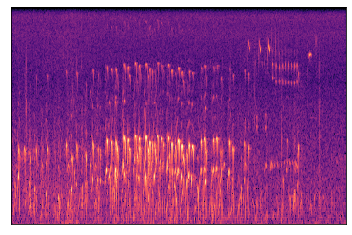

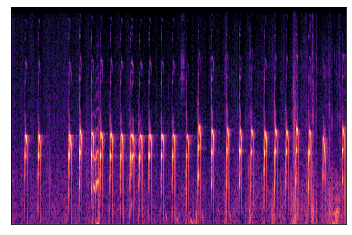

In [9]:
# bird: ameavo
createMelSpectrogram(SOUND_DIR_SUB + "ameavo", "XC133080.mp3", "", 1)
createMelSpectrogram(SOUND_DIR_SUB + "ameavo", "XC139829.mp3", "", 1)

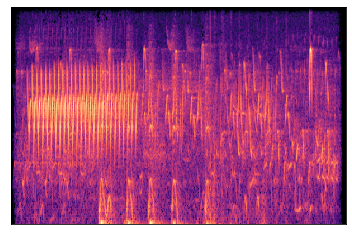

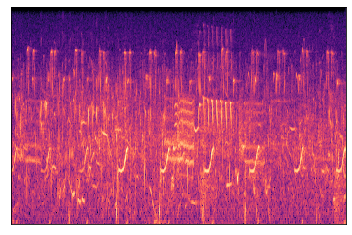

In [10]:
# bird: amebit
createMelSpectrogram(SOUND_DIR_SUB + "amebit", "XC141316.mp3", "", 1)
createMelSpectrogram(SOUND_DIR_SUB + "amebit", "XC184876.mp3", "", 1)

## Set Model Parameters

In [11]:
# select 20 birds for training
# although the dataset has 240 birds, we will consider only 20 birds for our training
# this is due to time and compute cost constraints

#BIRDS = os.listdir(SOUND_DIR_SUB)[0:20]

BIRDS = ["amered",  "annhum",  "belkin1",  "blugrb1",  "brthum",  
         "cedwax",  "commer",  "gockin",  "gryfly",  "horlar",  
         "moudov",  "olsfly",  "pasfly",  "semsan",  "sposan",
         "vigswa",  "wewpew",  "whbnut",  "wilsni1",  "yelwar"]

# set common settings and params
BATCH_SIZE = 16
TRAINABLE = False
MODEL_NAME = "imgnet_mobilenet_v2_140_224"
EPOCHS = 5
IM_SIZE = get_model_img_size(MODEL_NAME)
IM_SIZE

(224, 224, 3)

## Augment Bird Audio Samples

In [12]:
# Specify bird list that needs augmentation
# For all birds, leave it without parameters
# Since we have pre-augmented all our training samples, we skip this step
#augment_multiple_birds(["aldfly"])

## Create Mel-Spectrograms for Training

In [13]:

train_folder = SOUND_DIR+"train_data_decibel_20/"
val_folder = SOUND_DIR+"val_data_decibel_20/"

if not os.path.exists(train_folder): os.mkdir(train_folder)
if not os.path.exists(val_folder): os.mkdir(val_folder)
    
print(train_folder)
print(val_folder)

# these are the folders where we have kept our training and validation augmented data
# since this is mounted already with IBM storage, we expect these paths to exist

/project/data/train_data_decibel_20/
/project/data/val_data_decibel_20/


In [14]:
###########################################################
####  This will take a long time to run
####  Hence, we have already created the images for 20 birds 
####  and will use that for our training
###########################################################

# create train and val spectrogram
np.random.seed(1234)
for bird in tqdm(BIRDS):
    INPUT_DIR = os.path.join(SOUND_DIR_SUB, bird)
    TRAIN_DIR = os.path.join(train_folder, bird)
    VAL_DIR = os.path.join(val_folder, bird)
    
    # create folders
    if not(os.path.exists(TRAIN_DIR)) and not(os.path.exists(VAL_DIR)): 
        
        os.mkdir(TRAIN_DIR)
        os.mkdir(VAL_DIR)

        # split into train and val set
        for f in os.listdir(INPUT_DIR):
            rand = np.random.randint(0, 10)
            if f[0] != ".":
                if rand <= 7: 
                    createMelSpectrogram(INPUT_DIR, f, TRAIN_DIR)
                else:
                    createMelSpectrogram(INPUT_DIR, f, VAL_DIR)        

100%|██████████| 20/20 [00:00<00:00, 11349.76it/s]


## Create Training and Test Batches

In [15]:
# create data generator - uses the ImageDataGenerator from Keras
datagen = ImageDataGenerator(preprocessing_function=None,
                             rescale=1/255,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.1,
                             fill_mode='nearest')

# generate train batches
train_batches = datagen.flow_from_directory(train_folder,
                                            classes=BIRDS, 
                                            target_size=IM_SIZE[0:2], 
                                            class_mode='categorical', 
                                            shuffle=True, batch_size=BATCH_SIZE)

# generate validation batches
val_batches = datagen.flow_from_directory(val_folder,
                                          classes=BIRDS, 
                                          target_size=IM_SIZE[0:2], 
                                          class_mode='categorical', 
                                          shuffle=False, batch_size=1)

# estimate class weights for unbalanced datasets.
class_weights = class_weight.compute_class_weight('balanced', 
                                                  np.unique(train_batches.classes), 
                                                  train_batches.classes)

Found 27794 images belonging to 20 classes.
Found 6710 images belonging to 20 classes.


## Create Model and Train 

In [16]:
# the below URL gets the headless model from tf2 hub
feature_extractor_url = get_model_url(MODEL_NAME, 4)

# create feature extractor from prebuilt model using Keras
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=IM_SIZE)

# informational
for image_batch, label_batch in train_batches:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

# informational
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

# we can choose to lock the layers except the top layer (or not)
feature_extractor_layer.trainable = TRAINABLE

# attach a classification head and create the model object
model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(len(BIRDS), activation='softmax', name='softmax')
])

model.summary()


Image batch shape:  (16, 224, 224, 3)
Label batch shape:  (16, 20)
(16, 1792)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1792)              4363712   
_________________________________________________________________
softmax (Dense)              (None, 20)                35860     
Total params: 4,399,572
Trainable params: 35,860
Non-trainable params: 4,363,712
_________________________________________________________________


In [17]:
model.compile(optimizer = tf.keras.optimizers.Adam(), 
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics = ['accuracy'])

In [18]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['accuracy'])
    self.model.reset_metrics()

In [19]:
batch_stats_callback = CollectBatchStats()

history = model.fit_generator(train_batches, 
                              epochs = EPOCHS,
                              validation_data = val_batches,
                              steps_per_epoch = int(len(train_batches.classes)/BATCH_SIZE)+1,
                              validation_steps = len(val_batches.classes),
                              callbacks = [batch_stats_callback],
                              class_weight = {i:class_weights[i] for i in range(len(BIRDS))})


Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/5
1738/1738 [==============================] - 18399s 11s/step - loss: 2.4053 - accuracy: 0.3750 - val_loss: 2.7492 - val_accuracy: 0.3414
Epoch 2/5
1738/1738 [==============================] - 18075s 10s/step - loss: 2.7268 - accuracy: 0.4375 - val_loss: 2.7088 - val_accuracy: 0.3818
Epoch 3/5
1738/1738 [==============================] - 17567s 10s/step - loss: 2.6481 - accuracy: 0.5625 - val_loss: 2.6831 - val_accuracy: 0.4113
Epoch 4/5
1738/1738 [==============================] - 17680s 10s/step - loss: 2.7750 - accuracy: 0.5625 - val_loss: 2.6867 - val_accuracy: 0.4033
Epoch 5/5
1738/1738 [==============================] - 17265s 10s/step - loss: 2.3503 - accuracy: 0.6875 - val_loss: 2.6854 - val_accuracy: 0.4037


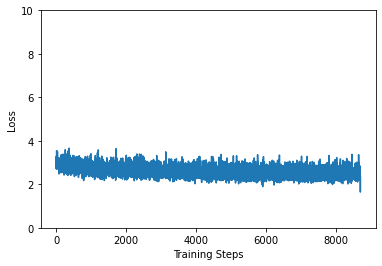

In [20]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,10])
plt.plot(batch_stats_callback.batch_losses)

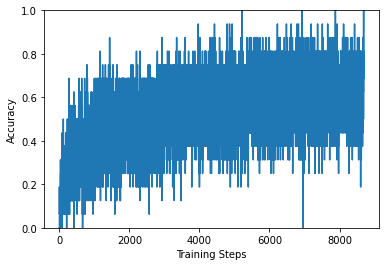

In [21]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [22]:
t = time.ctime().replace(" ","_").replace(":","_")

export_path = "models/{}/{}".format(MODEL_NAME, t)
model.save(export_path, save_format='tf')

export_path

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: models/imgnet_mobilenet_v2_140_224/Fri_Jul_24_02_35_06_2020/assets


INFO:tensorflow:Assets written to: models/imgnet_mobilenet_v2_140_224/Fri_Jul_24_02_35_06_2020/assets


'models/imgnet_mobilenet_v2_140_224/Fri_Jul_24_02_35_06_2020'

In [23]:
reloaded = tf.keras.models.load_model(export_path)
print("Accuracy on val data for model: {}".format(MODEL_NAME))
reloaded.evaluate(val_batches, steps=len(val_batches.classes))[1]

Accuracy on val data for model: imgnet_mobilenet_v2_140_224
6710/6710 [==============================] - 3336s 497ms/step - loss: 2.6839 - accuracy: 0.4086


0.40864381194114685

## Compare Against Original EfficientNet Model

In [24]:
# The original model was included as a part of this blog
# https://towardsdatascience.com/sound-based-bird-classification-965d0ecacb2b
# Here, we also use a similar headless model approach, because "include_top" is false
net = efn.EfficientNetB3(include_top=False, weights="imagenet", input_tensor=None, input_shape=IM_SIZE)
net.trainable = TRAINABLE

x = net.output

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)

output_layer = tf.keras.layers.Dense(len(BIRDS), activation='softmax', name='softmax')(x)
net_final = tf.keras.Model(inputs=net.input, outputs=output_layer)

net_final.compile(optimizer=tf.keras.optimizers.Adam(), 
                  loss = 'categorical_crossentropy', metrics = ['accuracy'])

checkpoint_path = 'models/efficientnet/efficientnet_checkpoint.h5'
#net_final.summary()

44113920/44107200 [==============================] - 2s 0us/step


In [ ]:
ModelCheck = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=0, 
                             save_best_only=True, save_weights_only=True, mode='auto')

net_final.reset_states()
net_final.fit_generator(train_batches, 
                        validation_data = val_batches,
                        steps_per_epoch = int(len(train_batches.classes)/BATCH_SIZE)+1,
                        validation_steps = len(val_batches.classes),
                        epochs = EPOCHS, 
                        callbacks = [ModelCheck],
                        class_weight = {i:class_weights[i] for i in range(len(BIRDS))})

Epoch 1/5
 687/1738 [==========>...................] - ETA: 2:20:51 - loss: 2.4566 - accuracy: 0.2655

In [ ]:
net_final.load_weights(checkpoint_path)
print("Accuracy on val data with efficientnet")
net_final.evaluate(val_batches, steps=len(val_batches.classes))[1]